In [2]:
#  https://github.com/fchollet/deep-learning-with-python-notebooks
import keras
keras.__version__ #133 / 373

Using TensorFlow backend.


'2.3.1'

# 5.1 - Introduction to convnets


First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in Chapter 2, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter 2.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [7]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 1s 0us/step


In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.1626 - accuracy: 0.9493
Epoch 2/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0445 - accuracy: 0.9865
Epoch 3/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0318 - accuracy: 0.9907
Epoch 4/5
60000/60000 [==============================] - 3s 58us/step - loss: 0.0241 - accuracy: 0.9926
Epoch 5/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0187 - accuracy: 0.9943


Let's evaluate the model on the test data:

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 63us/step


In [10]:
test_acc

0.9912999868392944

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 

This key characteristic gives convnets two interesting properties:

1. `The patterns they learn are translation invariant`. After learning a certain pattern in
the lower-right corner of a picture, a convnet can recognize it anywhere: for
example, in the upper-left corner. A densely connected network would have to
learn the pattern anew if it appeared at a new location. This makes convnets
data efficient when processing images (because the visual world is fundamentally
translation invariant): they need fewer training samples to learn representations
that have generalization power.

2. `They can learn spatial hierarchies of patterns` (see figure 5.2). A first convolution layer
will learn small local patterns such as edges, a second convolution layer will
learn larger patterns made of the features of the first layers, and so on. This
allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical)


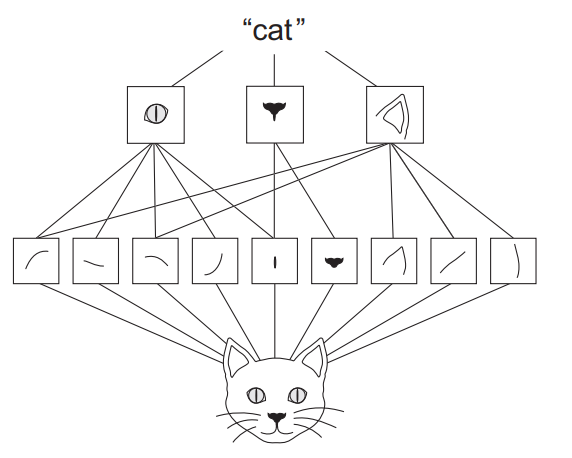

In [0]:
from IPython.display import *
Image(filename='./image/Picture18.png')

Convolutions operate over 3D tensors, called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis)

## **In the MNIST example,**

1. the first convolution layer takes a feature map of size (28, 28, 1) and 

2. outputs a feature map of size (26, 26, 32)

## **Convolutions are defined by two key parameters:**

 Size of the patches extracted from the inputs—These are typically 3 × 3 or 5 × 5. In the example, they were 3 × 3, which is a common choice.

 Depth of the output feature map—The number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer:
Conv2D(output_depth, (window_height, window_width)). 
A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the 3D input
feature map, stopping at every possible location, and extracting the 3D patch of surrounding features (shape (window_height, window_width, input_depth)). Each
such 3D patch is then transformed (via a tensor product with the same learned weight
matrix, called the convolution kernel) into a 1D vector of shape (output_depth,). All of
these vectors are then spatially reassembled into a 3D output map of shape (height,
width, output_depth). Every spatial location in the output feature map corresponds
to the same location in the input feature map (for example, the lower-right corner of
the output contains information about the lower-right corner of the input). For
instance, with 3 × 3 windows, the vector output[i, j, :] comes from the 3D patch
input[i-1:i+1, j-1:j+1, :]. The full process is detailed in figure 5.4.

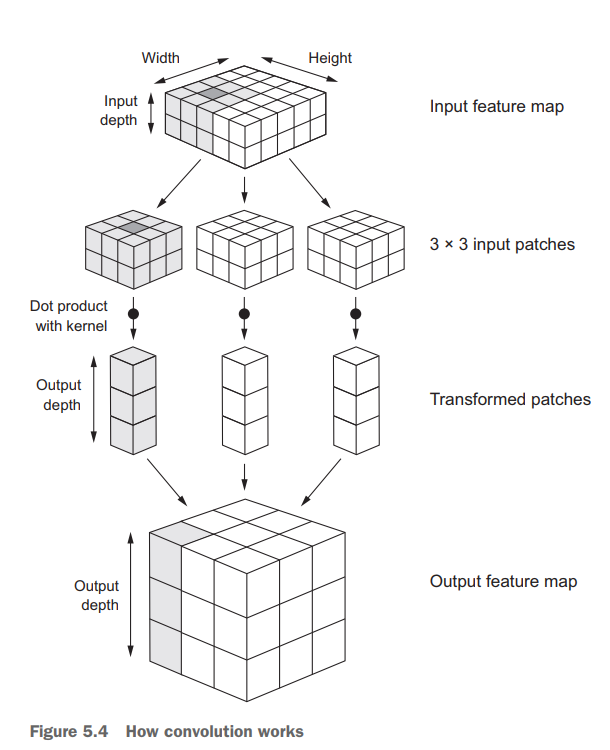

In [0]:
Image(filename='./image/Picture19.png')

## Note that the output width and height may differ from the input width and height.
They may differ for two reasons:**
1. Border effects, which can be countered by padding the input feature map
1. The use of strides, which I’ll define in a second

## UNDERSTANDING BORDER EFFECTS AND PADDING
Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you
can center a 3 × 3 window, forming a 3 × 3 grid (see figure 5.5). Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case. You can see this border effect in action in the earlier example: you start
with 28 × 28 inputs, which become 26 × 26 after the first convolution layer.

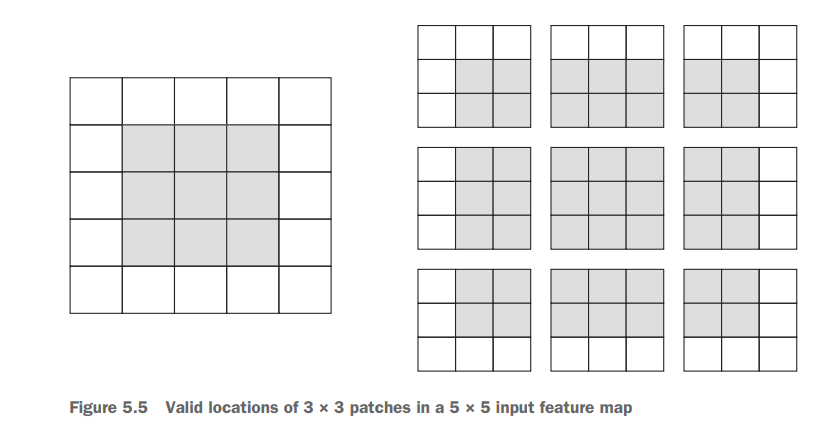

In [0]:
from IPython.display import *
Image(filename='./image/Picture20.png')

## UNDERSTANDING CONVOLUTION STRIDES

The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the
convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1.  Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects).

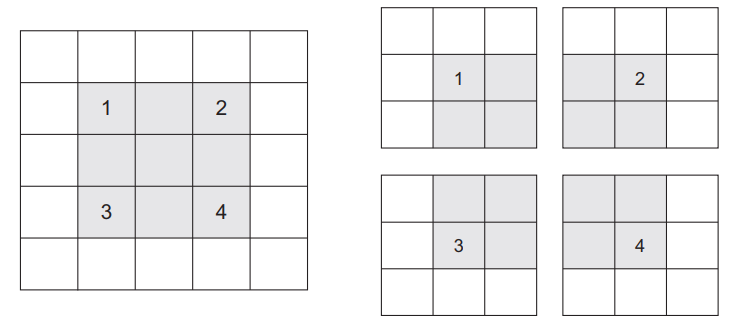

In [0]:
Image(filename='./image/Picture21.png')

## The max-pooling operation
In the convnet example, you may have noticed that the size of the feature maps is
halved after every MaxPooling2D layer. For instance, before the first MaxPooling2D layers, the feature map is 26 × 26, but the max-pooling operation halves it to 13 × 13.
That’s the role of max pooling: to aggressively downsample feature maps, much like
strided convolutions.
Max pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It’s conceptually similar to convolution, except
that instead of transforming local patches via a learned linear transformation 

## What’s wrong with this setup? Two things:
 It isn’t conducive to learning a spatial hierarchy of features. The 3 × 3 windows
in the third layer will only contain information coming from 7 × 7 windows in
the initial input. The high-level patterns learned by the convnet will still be very
small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are
7 × 7 pixels!). We need the features from the last convolution layer to contain
information about the totality of the input.

 The final feature map has 22 × 22 × 64 = 30,976 total coefficients per sample.
This is huge. If you were to flatten it to stick a Dense layer of size 512 on top,
that layer would have 15.8 million parameters. This is far too large for such a
small model and would result in intense overfitting.

In short, the reason to use downsampling is to reduce the number of feature-map
coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows (in terms of the fraction of
the original input they cover).

Note that max pooling isn’t the only way you can achieve such downsampling. As
you already know, you can also use strides in the prior convolution layer. And you can use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the
max. But max pooling tends to work better than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern
or concept over the different tiles of the feature map (hence, the term feature map),
and it’s more informative to look at the maximal presence of different features than at
their average presence. So the most reasonable subsampling strategy is to first produce
dense maps of features (via unstrided convolutions) and then look at the maximal
activation of the features over small patches, rather than looking at sparser windows of
the inputs (via strided convolutions) or averaging input patches, which could cause
you to miss or dilute feature-presence information.


## END 5.1 

# 5.2 - Using convnets with small datasets

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We 
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be 
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce 
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve 
our network to reach an accuracy of 82%.

In the next step: 
* training a small model from scratch, 
* doing feature extracting using a 
pre-trained model, and 
* fine-tuning a pre-trained model

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual 
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because convnets learn local, translation-invariant features, they are very 
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: 
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
# !unzip '/content/drive/My Drive/Colab Notebooks/Project/cats_and_dogs_small.zip'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !unzip '/content/drive/My Drive/Colab Notebooks/Project/cats_and_dogs_small.zip'


In [0]:
import os
train_dir = '/content/cats_and_dogs_small/train'
validation_dir='/content/cats_and_dogs_small/validation'
test_dir='/content/cats_and_dogs_small/test'

train_dogs_dir = '/content/cats_and_dogs_small/train/dogs'
validation_dogs_dir = '/content/cats_and_dogs_small/validation/dogs'
test_dogs_dir = '/content/cats_and_dogs_small/test/dogs'

train_cats_dir = '/content/cats_and_dogs_small/train/cats'
validation_cats_dir = '/content/cats_and_dogs_small/validation/cats'
test_cats_dir = '/content/cats_and_dogs_small/test/cats'

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [14]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [0]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [18]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Understanding Python generators
A Python generator is an object that acts as an iterator: it’s an object you can use
with the for … in operator. Generators are built using the yield operator.
Here is an example of a generator that yields integers:


```
# This is formatted as code
def generator():
    i = 0
    while True:
        i += 1
        yield i
    for item in generator():
        print(item)
        if item > 4:
        break
```


It prints this:
1 2 3 4 5


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [19]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 9s 85ms/step - loss: 0.6933 - acc: 0.5180 - val_loss: 0.6855 - val_acc: 0.5590
Epoch 2/30
100/100 [==============================] - 8s 78ms/step - loss: 0.6672 - acc: 0.6040 - val_loss: 0.7615 - val_acc: 0.5120
Epoch 3/30
100/100 [==============================] - 8s 76ms/step - loss: 0.6285 - acc: 0.6620 - val_loss: 0.4549 - val_acc: 0.6080
Epoch 4/30
100/100 [==============================] - 8s 76ms/step - loss: 0.5925 - acc: 0.6955 - val_loss: 0.4670 - val_acc: 0.6780
Epoch 5/30
100/100 [==============================] - 8s 76ms/step - loss: 0.5460 - acc: 0.7165 - val_loss: 0.4267 - val_acc: 0.6280
Epoch 6/30
100/100 [==============================] - 8s 76ms/step - loss: 0.5306 - acc: 0.7370 - val_loss: 0.5359 - val_acc: 0.6990
Epoch 7/30
100/100 [==============================] - 8s 77ms/step - loss: 0.4976 - acc: 0.7500 - val_loss: 0.6706 - val_acc: 0.7000
Epoch 8/30
100/100 [==============================] - 8s 76ms/step - 

It is good practice to always save your models after training:

In [0]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

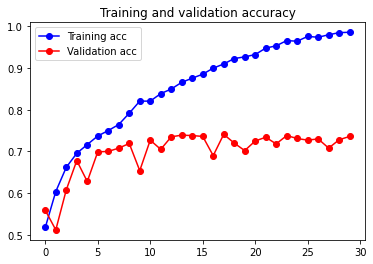

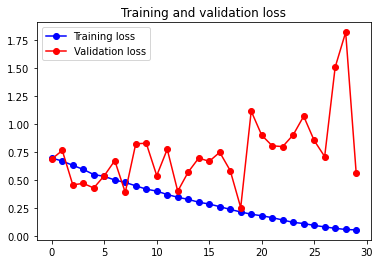

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

`These plots are characteristic of overfitting.` Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

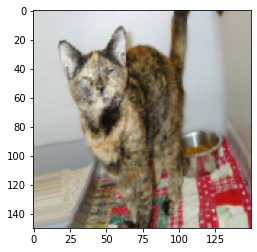

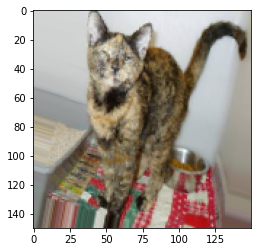

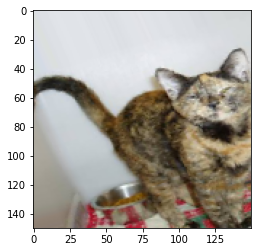

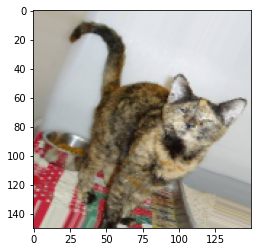

In [24]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 27s 270ms/step - loss: 0.6958 - acc: 0.5066 - val_loss: 0.6873 - val_acc: 0.5888
Epoch 2/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6876 - acc: 0.5552 - val_loss: 0.7983 - val_acc: 0.4942
Epoch 3/100
100/100 [==============================] - 24s 243ms/step - loss: 0.6746 - acc: 0.5823 - val_loss: 0.6697 - val_acc: 0.6142
Epoch 4/100
100/100 [==============================] - 24s 243ms/step - loss: 0.6633 - acc: 0.5955 - val_loss: 0.7145 - val_acc: 0.5883
Epoch 5/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6516 - acc: 0.6074 - val_loss: 0.6661 - val_acc: 0.5552
Epoch 6/100
100/100 [==============================] - 26s 259ms/step - loss: 0.6272 - acc: 0.6493 - val_loss: 0.5825 - val_acc: 0.6695
Epoch 7/100
100/100 [==============================] - 24s 245ms/step - loss: 0.6179 - acc: 0.6555 -

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

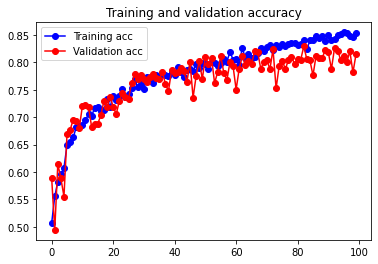

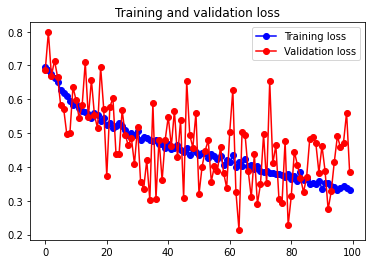

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two 
sections.

# 5.3 Using a pre-trained convnet


----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.

[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import keras
keras.__version__
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

Using TensorFlow backend.


'2.3.1'

In [0]:
# !unzip '/content/drive/My Drive/Colab Notebooks/Project/cats_and_dogs_small.zip'

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* `Xception`
* `InceptionV3`
* `ResNet50`
* `VGG16`
* `VGG19`
* `MobileNet`

Let's instantiate the VGG16 model:

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [31]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
test_labels[1:10]

array([1., 0., 0., 1., 1., 1., 1., 1., 1.])

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [34]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 267us/step - loss: 0.6063 - acc: 0.6665 - val_loss: 0.4371 - val_acc: 0.8360
Epoch 2/30
2000/2000 [==============================] - 0s 216us/step - loss: 0.4305 - acc: 0.8055 - val_loss: 0.3579 - val_acc: 0.8670
Epoch 3/30
2000/2000 [==============================] - 0s 228us/step - loss: 0.3566 - acc: 0.8495 - val_loss: 0.3199 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 0s 223us/step - loss: 0.3188 - acc: 0.8670 - val_loss: 0.2981 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 0s 218us/step - loss: 0.2816 - acc: 0.8910 - val_loss: 0.2855 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 0s 222us/step - loss: 0.2647 - acc: 0.8950 - val_loss: 0.2757 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 0s 219us/step - loss: 0.2495 - acc: 0.8995 - val_loss: 0.2737 - val_acc: 0.8880


Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

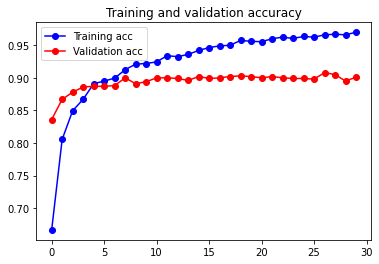

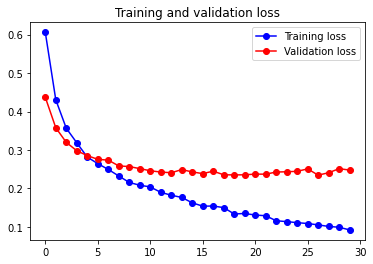

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.
## FEATURE EXTRACTION WITH DATA AUGMENTATION

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. 

**Note:** that this 
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you 
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. 

**"Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.**

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [38]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [40]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [41]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 18s - loss: 0.5864 - acc: 0.7115 - val_loss: 0.4500 - val_acc: 0.7730
Epoch 2/30
 - 16s - loss: 0.4827 - acc: 0.7830 - val_loss: 0.3561 - val_acc: 0.8480
Epoch 3/30
 - 16s - loss: 0.4457 - acc: 0.8035 - val_loss: 0.3258 - val_acc: 0.8640
Epoch 4/30
 - 16s - loss: 0.4249 - acc: 0.8135 - val_loss: 0.2333 - val_acc: 0.8730
Epoch 5/30
 - 16s - loss: 0.3915 - acc: 0.8290 - val_loss: 0.3113 - val_acc: 0.8720
Epoch 6/30
 - 16s - loss: 0.3773 - acc: 0.8340 - val_loss: 0.3025 - val_acc: 0.8680
Epoch 7/30
 - 16s - loss: 0.3618 - acc: 0.8380 - val_loss: 0.2595 - val_acc: 0.8800
Epoch 8/30
 - 16s - loss: 0.3600 - acc: 0.8445 - val_loss: 0.2228 - val_acc: 0.8840
Epoch 9/30
 - 16s - loss: 0.3473 - acc: 0.8465 - val_loss: 0.3514 - val_acc: 0.8830
Epoch 10/30
 - 16s - loss: 0.3384 - acc: 0.8525 - val_loss: 0.1854 - val_acc: 0.8890
Epoch 11/30
 - 16s - loss: 0.3378 - acc: 0.8500 - val_loss: 0.4414 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

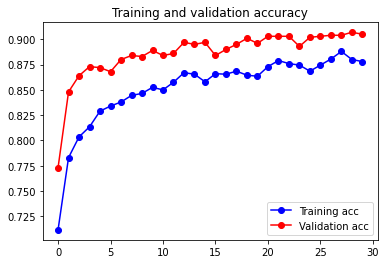

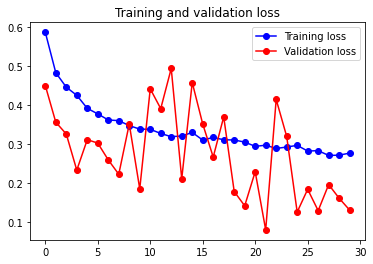

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![Fine-tuning the last convolutional block of the VGG16 network](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [44]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 183ms/step - loss: 0.2811 - acc: 0.8830 - val_loss: 0.0992 - val_acc: 0.9070
Epoch 2/100
100/100 [==============================] - 17s 168ms/step - loss: 0.2573 - acc: 0.8905 - val_loss: 0.1888 - val_acc: 0.8940
Epoch 3/100
100/100 [==============================] - 17s 167ms/step - loss: 0.2407 - acc: 0.9015 - val_loss: 0.3313 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 17s 168ms/step - loss: 0.2222 - acc: 0.9095 - val_loss: 0.0411 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 17s 169ms/step - loss: 0.2123 - acc: 0.9070 - val_loss: 0.3174 - val_acc: 0.9170
Epoch 6/100
100/100 [==============================] - 17s 166ms/step - loss: 0.2065 - acc: 0.9110 - val_loss: 0.3402 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 17s 169ms/step - loss: 0.1813 - acc: 0.9235 - val_loss: 0.6973 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

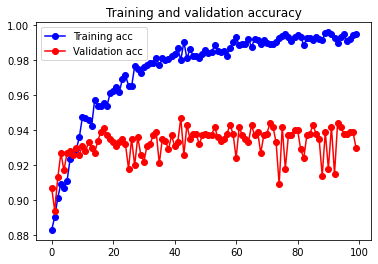

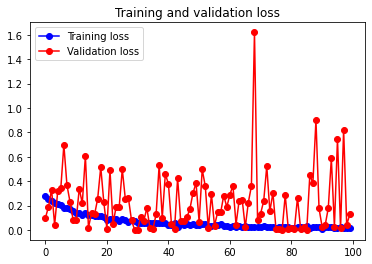

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

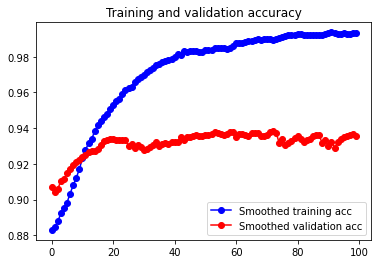

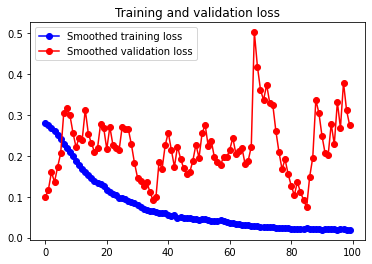

In [49]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'b-o', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r-o', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'b-o', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r-o', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [50]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9380000233650208



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.

# 5.4 Visualizing what convnets learn

----

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't 
survey all of them, but we will cover three of the most accessible and useful ones:

* *Visualizing intermediate convnet outputs ("intermediate activations")*. This is useful to understand how successive convnet layers 
transform their input, and to get a first idea of the meaning of individual convnet filters.
* *Visualizing convnets filters*. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive 
to.
* *Visualizing heatmaps of class activation in an image*. This is useful to understand which part of an image where identified as belonging 
to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog 
classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.

## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.
Let's start by loading the model that we saved in section 5.2:

In [51]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

In [52]:
img_path = 'cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

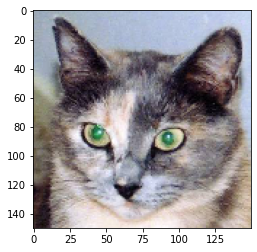

In [53]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. For more information about the `Model` class, see 
Chapter 7, Section 1.

In [0]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter 
a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [0]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

In [56]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

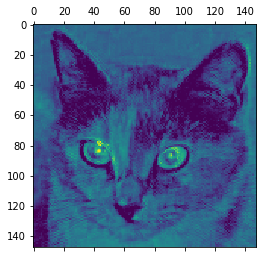

In [57]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the 
specific filters learned by convolution layers are not deterministic.

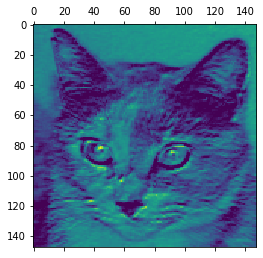

In [58]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


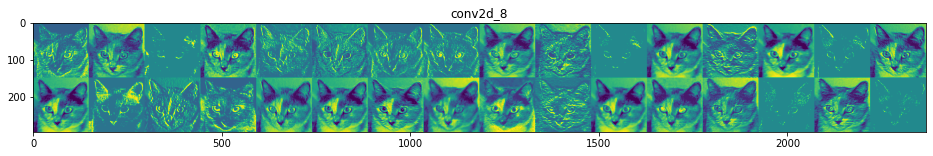

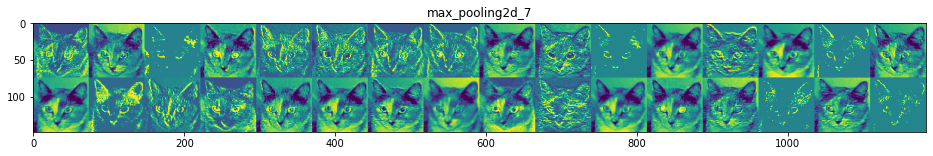

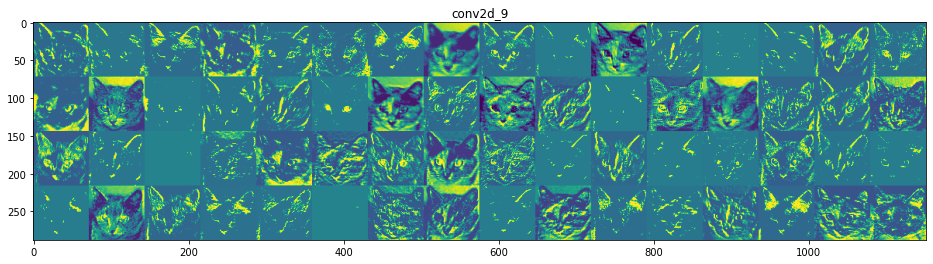

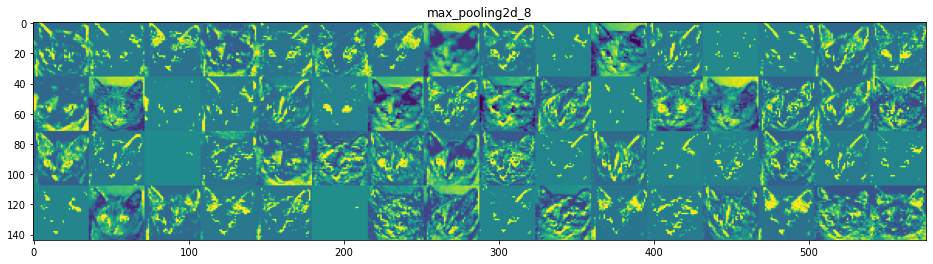

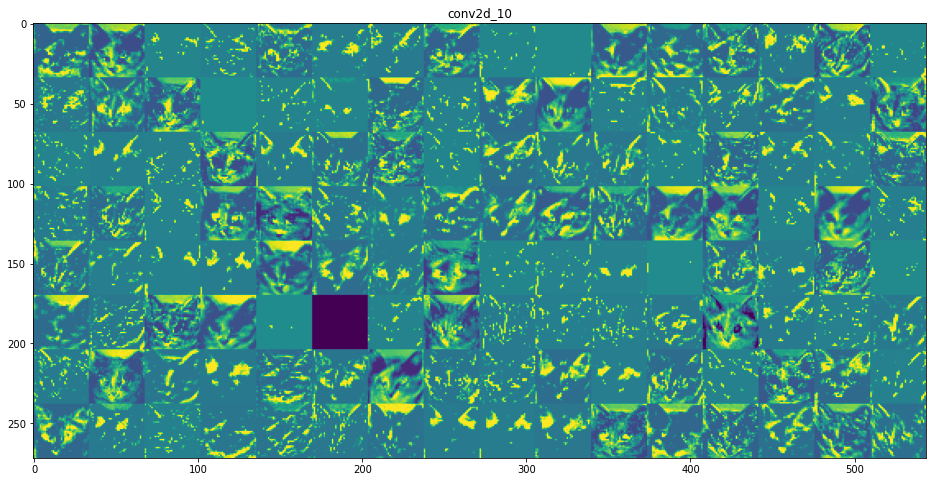

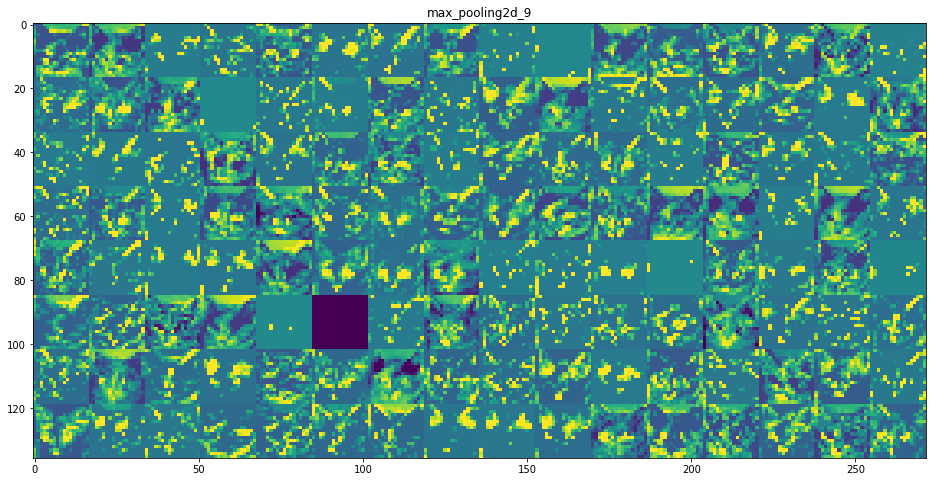

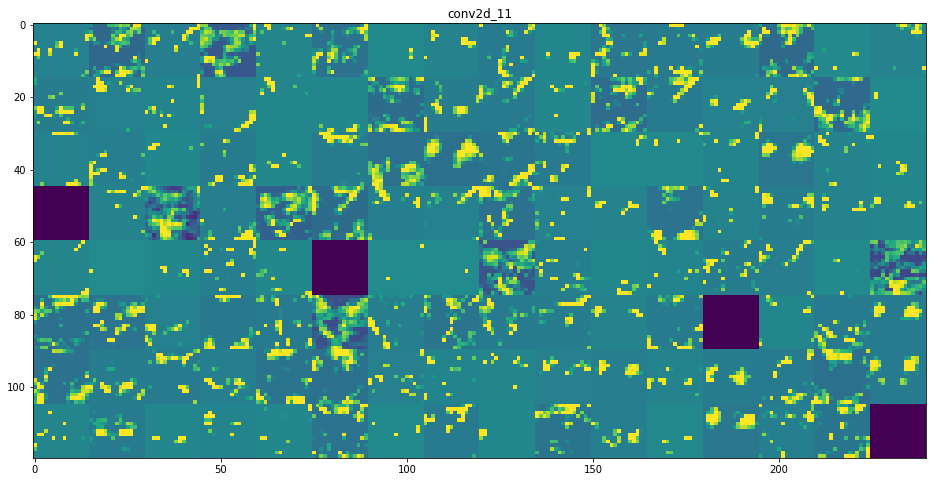

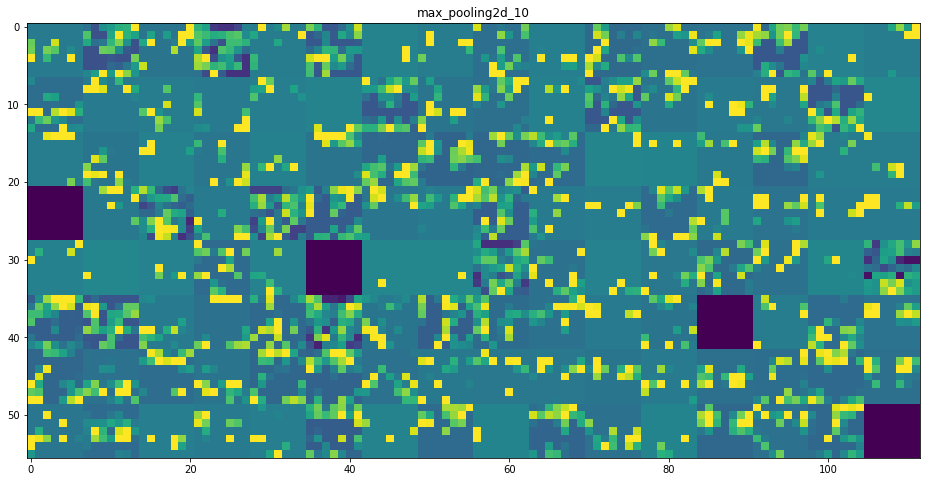

In [59]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the 
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level 
concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the 
image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input 
image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the 
input image.


We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features 
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less 
information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat 
or dog). A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which 
abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you 
tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen 
thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its 
visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

In [0]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the 
`gradients` function packaged with the `backend` module of Keras:

In [0]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 
norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the 
input image is always within a same range.

In [0]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend 
function to do this: `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy 
tensors: the loss value and the gradient value.

In [0]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent:

In [0]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape `(1, 150, 150, 3)`, with values that may not be integer within `[0, 
255]`. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward 
utility function:

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that 
returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

In [0]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

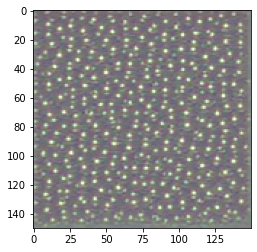

In [67]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in 
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, 
block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


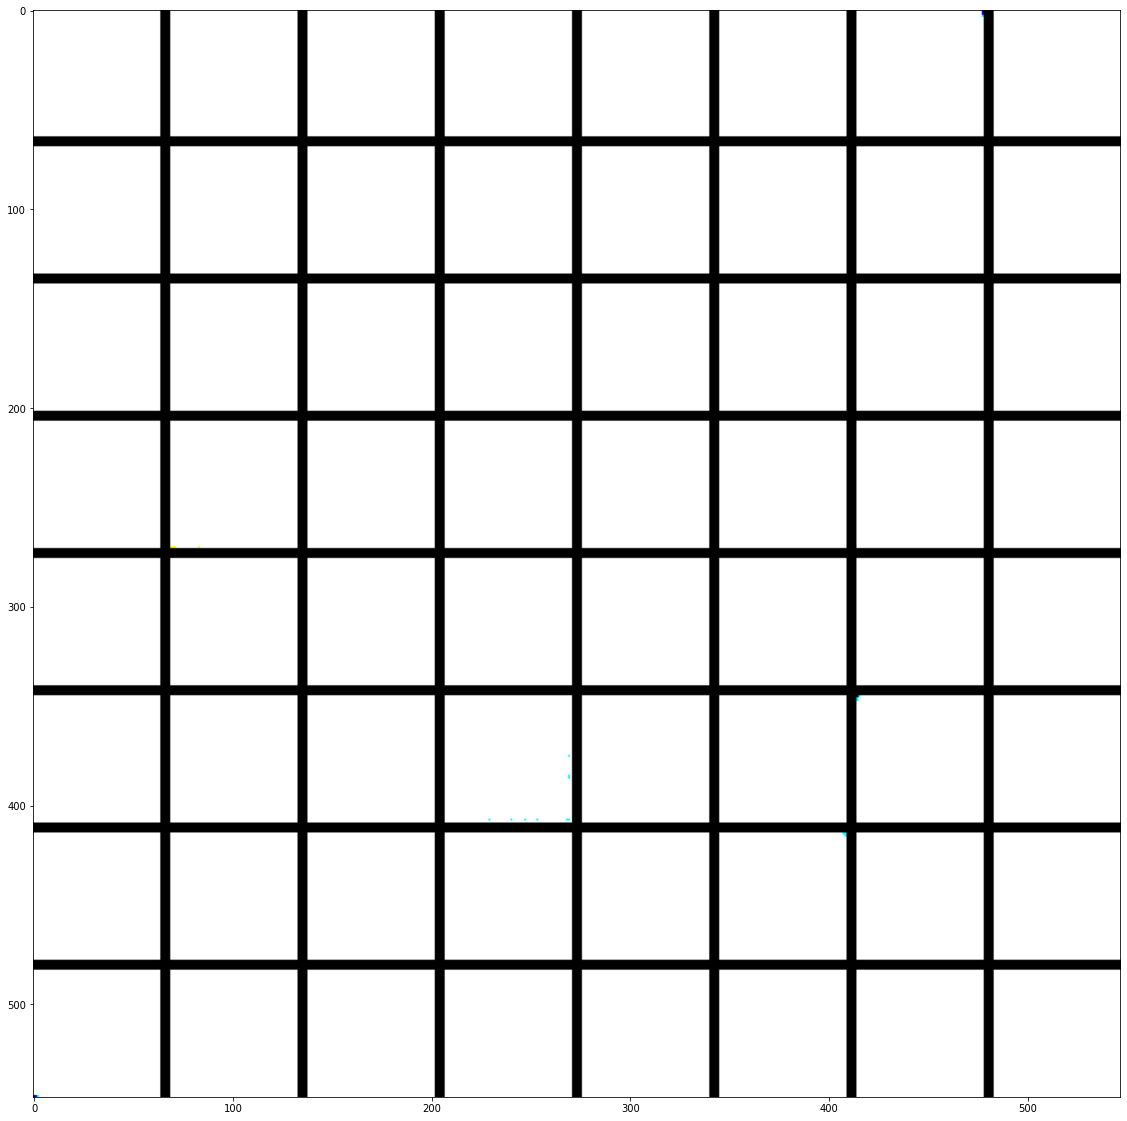

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


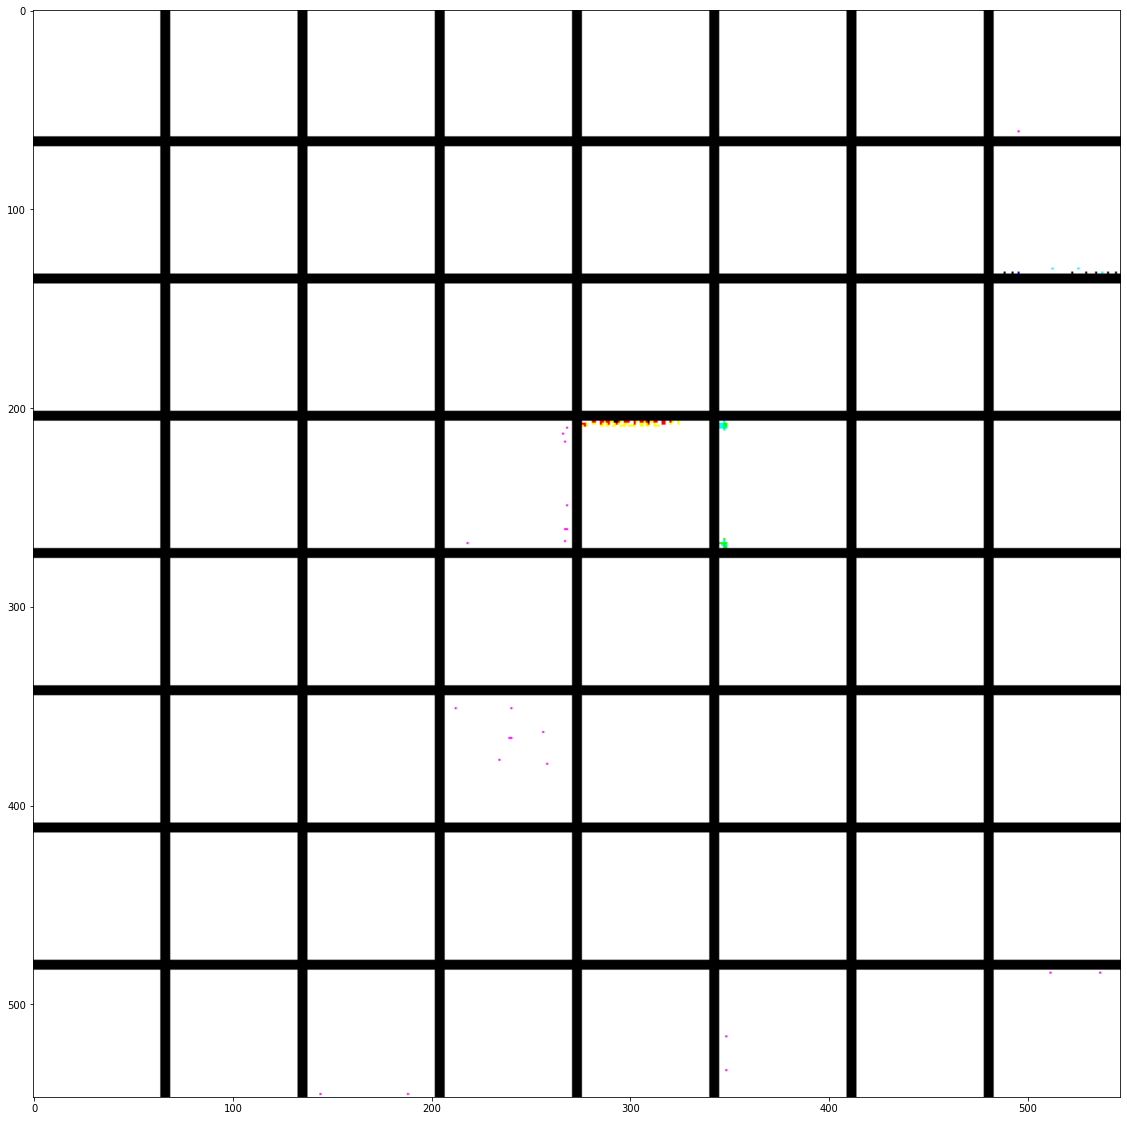

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


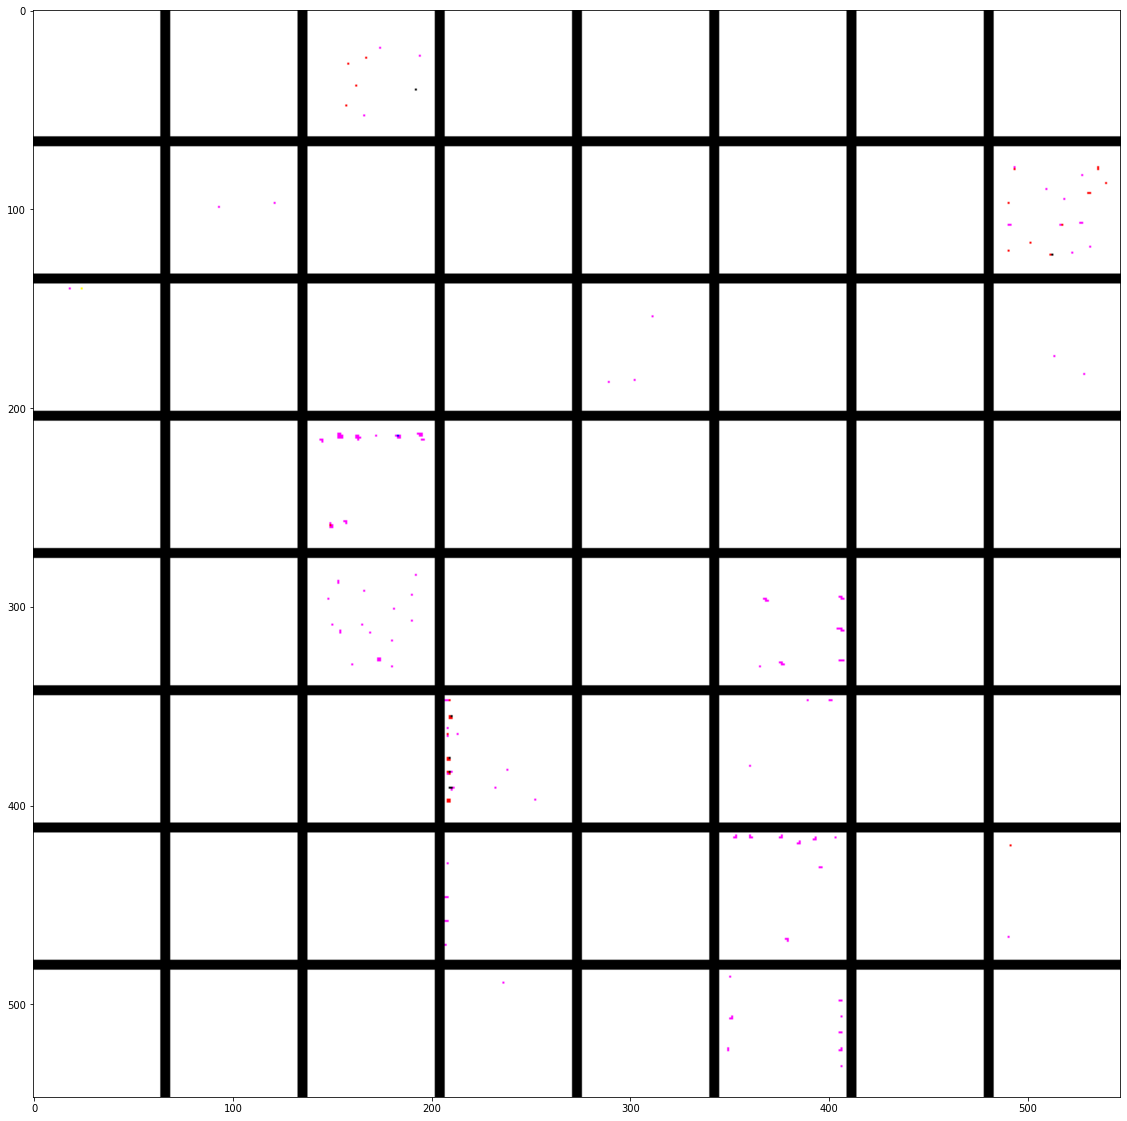

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


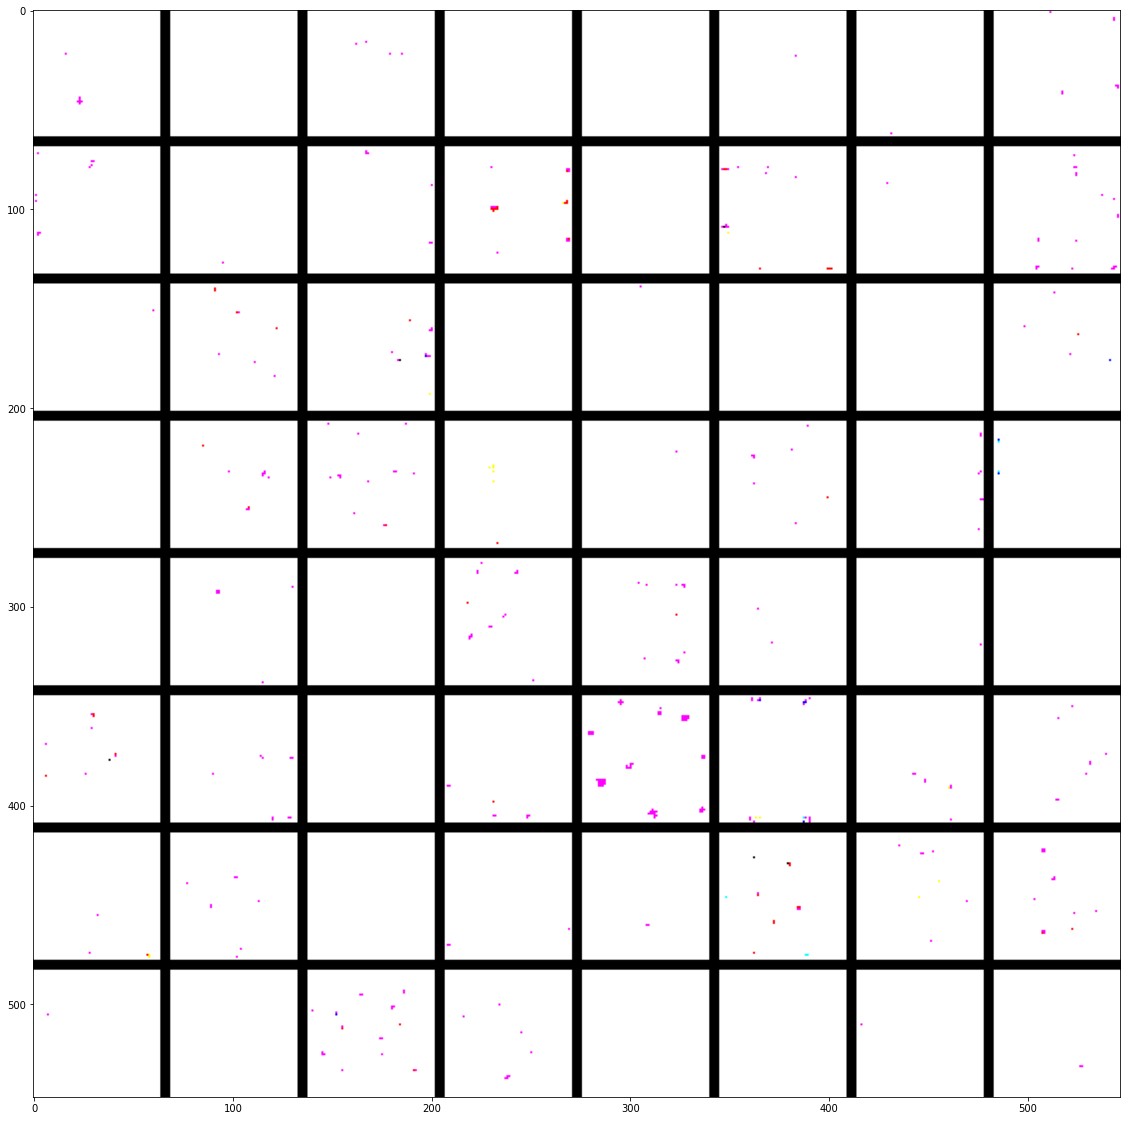

In [79]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of 
filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes 
signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up 
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [69]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 13s 0us/step


Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [73]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]



The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [74]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [0]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

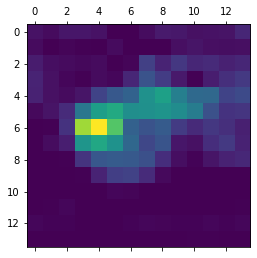

In [76]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [78]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.


# 5.5 Chapter summary

*  Convnets are the best tool for attacking visual-classification problems.
* Convnets work by learning a hierarchy of modular patterns and concepts
to represent the visual world.
* The representations they learn are easy to inspect—convnets are the
opposite of black boxes!
* You’re now capable of training your own convnet from scratch to solve an
image-classification problem.
* You understand how to use visual data augmentation to fight overfitting.
* You know how to use a pretrained convnet to do feature extraction and
fine-tuning.
* You can generate visualizations of the filters learned by your convnets, as
well as heatmaps of class activity.